In [ ]:
#https://github.com/tatsath/fin-ml/blob/master/Chapter%205%20-%20Sup.%20Learning%20-%20Regression%20and%20Time%20Series%20models/Case%20Study%201%20-%20Stock%20Price%20Prediction/StockPricePrediction.ipynb

## OBJETIVO:

USAR MODELOS DE APRENDIZADO SUPERVISIONADO PARA PREVER O PREÇO DAS AÇÕES DA MICROSOFT USANDO ATIVOS CORRELACIONADOS E SEU PRÓPRIO HISTÓRICO

## DADOS E PACOTES

In [1]:
#para os modelos
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
#para analises e avaliação dos modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2, f_regression
#modulos para as redes neurais
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from scikeras.wrappers import KerasRegressor
#modulos para time series
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
#preparação e visualização dos dados
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import pandas_datareader.data as web

## DADOS

In [2]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

# Baixar ações do Yahoo com yfinance
stk_data = yf.download(stk_tickers, start="2010-01-01", group_by='ticker')

# Baixar câmbio e índices do FRED (continua igual)
ccy_data = web.DataReader(ccy_tickers, 'fred', start='2010-01-01')
idx_data = web.DataReader(idx_tickers, 'fred', start='2010-01-01')


[*********************100%***********************]  3 of 3 completed


In [30]:
#definindo a variável independente (Y)
return_period = 5
Y = np.log(stk_data.loc[:,'MSFT'][['Close']]).diff(return_period).\
    shift(-return_period)
Y.columns = ["MSFT_pred"]

In [55]:
#montando a base
stk_data = stk_data.sort_index()
ccy_data = ccy_data.sort_index()
idx_data = idx_data.sort_index()
X1 = np.log(stk_data.loc[:,'GOOGL'][['Close']]).diff(return_period)
X2 = np.log(stk_data.loc[:,'IBM'][['Close']]).diff(return_period)
X1.columns  = ['GOOGL']
X2.columns  = ['IBM']
X1 = pd.concat([X1,X2], axis=1)
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
X4 =pd.concat([np.log(stk_data.loc[:,'MSFT'][['Close']]).diff(i)\
              for i in [return_period, return_period*3,\
               return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT','MSFT_3DT','MSFT_6DT','MSFT_12DT']
X = pd.concat([X1,X2,X3,X4], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, 'MSFT_pred']
X = dataset.loc[:, X.columns]

## ANÁLISE EXPLORATÓRIA

In [56]:
dataset.sort_index().head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2015-06-24,-0.026420,0.021663,-0.001197,-0.000080,-0.001720,0.003868,0.001690,-0.089397,-0.007204,-0.026166,-0.030304,0.114666
2015-07-01,0.001574,-0.027718,-0.014964,-0.009868,-0.004090,-0.014888,-0.011654,0.193446,-0.026420,-0.047450,-0.068047,0.074427
2015-07-09,0.046949,0.002482,-0.003898,-0.015715,-0.015425,-0.012340,-0.010289,0.173448,0.001574,-0.032050,-0.067104,0.073115
2015-07-17,-0.014693,0.229571,0.032761,0.010132,0.007775,0.023802,0.018191,-0.342432,0.044072,0.021026,0.005593,0.087540
2015-07-24,0.016408,-0.066253,-0.076845,-0.002099,-0.007065,-0.022344,-0.029054,0.139580,-0.014693,0.034097,-0.010824,-0.059230


In [57]:
#descritiva
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,0.005057,0.003119,0.001131,0.000213,-0.000642,0.001202,0.000818,0.004016,0.004214,0.014100,0.028288,0.056960
std,0.032180,0.039666,0.032813,0.012454,0.014044,0.023682,0.023217,0.169358,0.033236,0.054507,0.072172,0.094033
min,-0.107017,-0.131878,-0.130376,-0.045747,-0.111234,-0.133785,-0.168597,-0.552380,-0.107017,-0.198058,-0.246400,-0.263142
25%,-0.013201,-0.017914,-0.015835,-0.006232,-0.007401,-0.007107,-0.008780,-0.092963,-0.014029,-0.015649,-0.013413,-0.002047
50%,0.006718,0.004818,0.002510,0.001060,-0.000594,0.003907,0.003456,-0.011564,0.005442,0.021028,0.031792,0.064582
75%,0.024091,0.023074,0.019835,0.007370,0.007439,0.013795,0.012795,0.083433,0.024091,0.048528,0.076758,0.122644
max,0.105236,0.229571,0.128794,0.035792,0.052253,0.107173,0.112341,0.877037,0.105236,0.186488,0.227306,0.345888


A VARIÁVEL MSFT_pred É O RETORNO DA AÇÃO DA MICROSOFT E A VARIÁVEL RESPOSTA. AS DEMAIS VARIÁVEIS REPRESENTAM SÉRIES DEFASADAS DE OUTRAS AÇÕES, MOEDAS E ÍNDICES CORRELACIONADAS, ALÉM DE RETORNOS HISTÓRICOS DEFASADOS DA MSFT

### VISUALIZAÇÃO DOS DADOS

<Axes: title={'center': 'Matriz de Correlação'}>

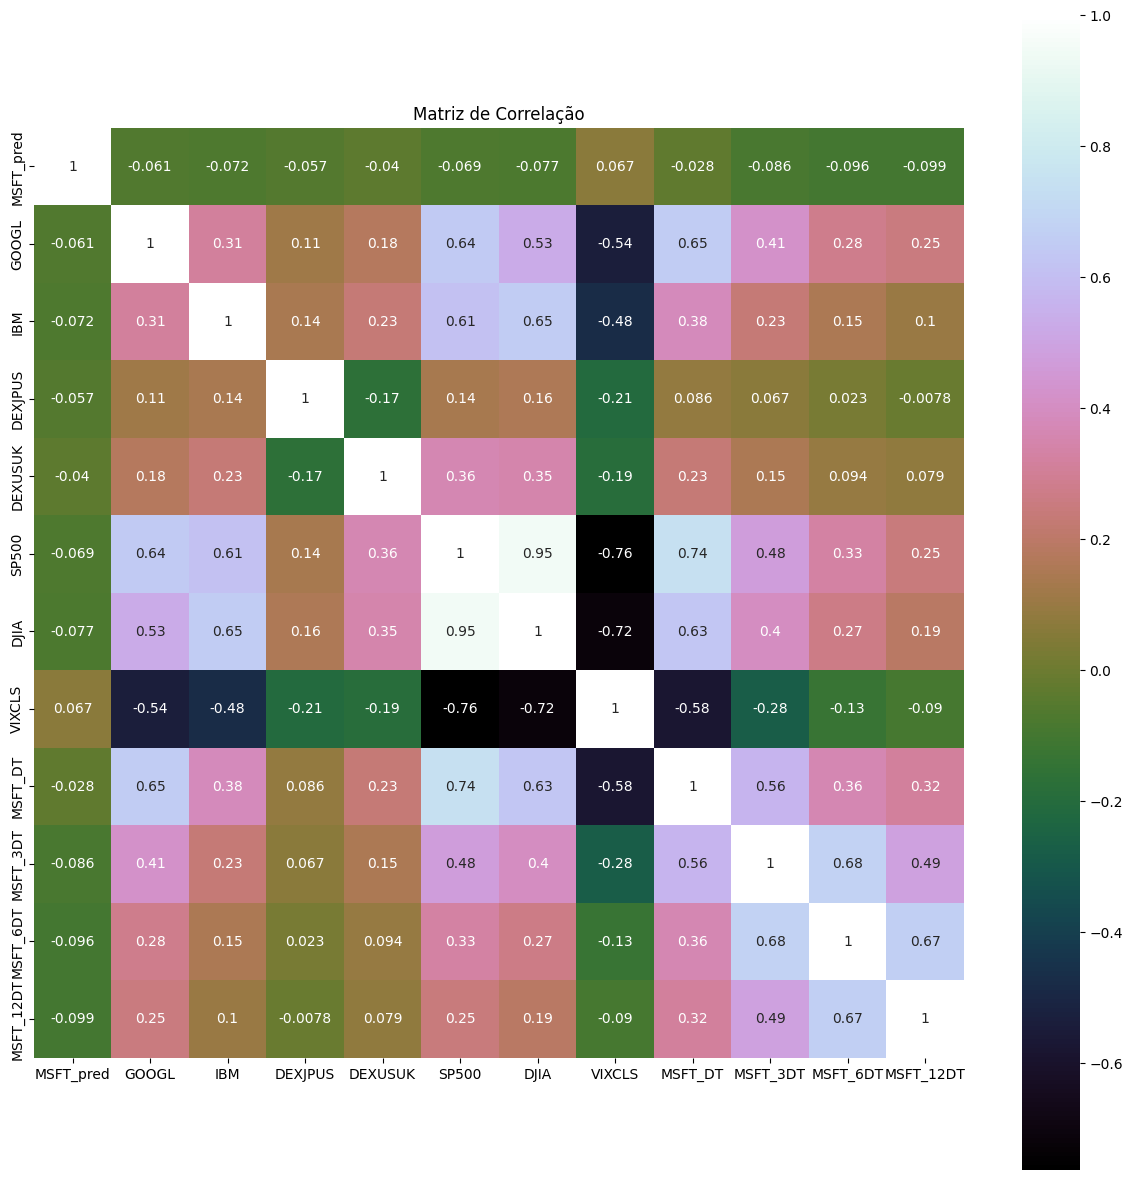

In [58]:
#CORRELAÇÃO
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title("Matriz de Correlação")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

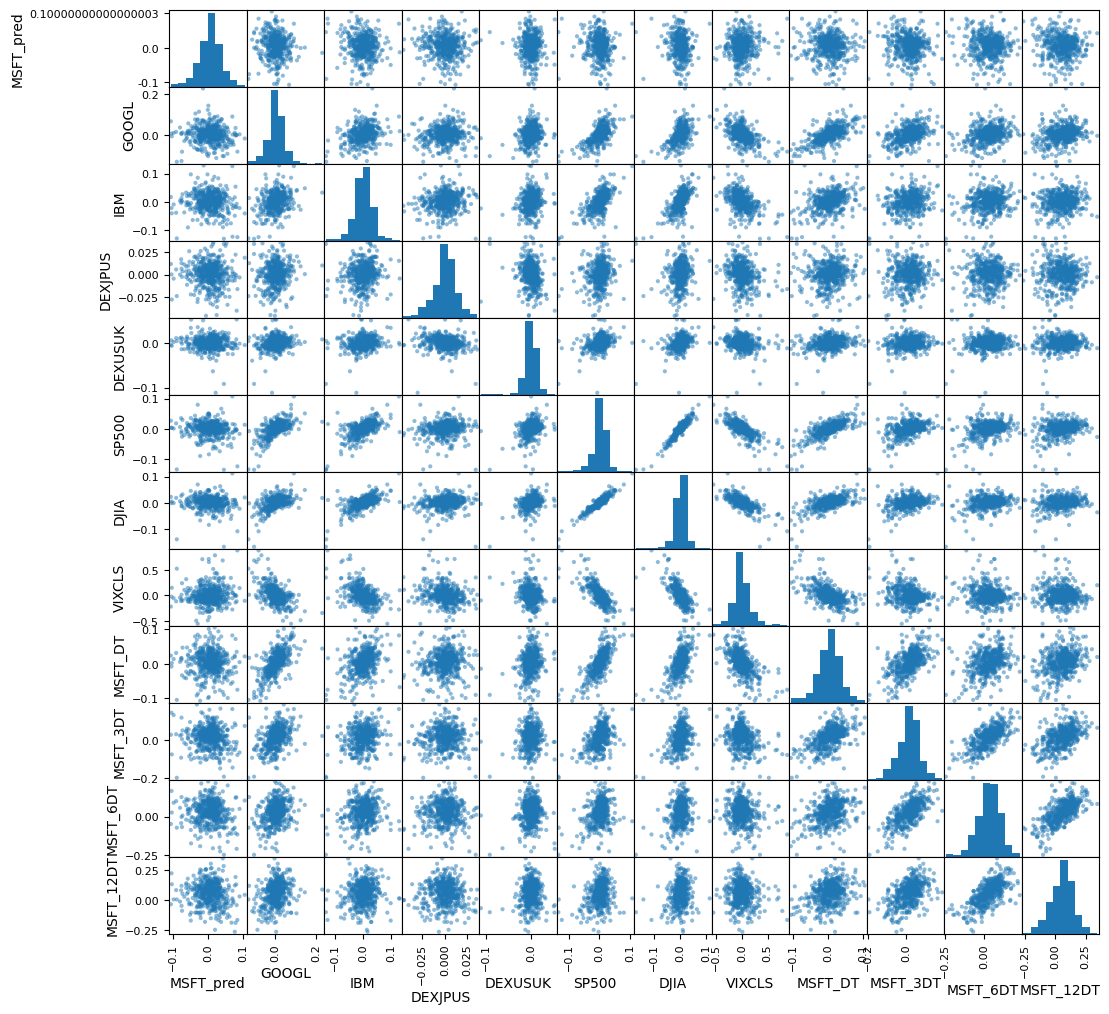

In [59]:
plt.figure(figsize=(15,15))
scatter_matrix(dataset, figsize = (12,12))
plt.show()

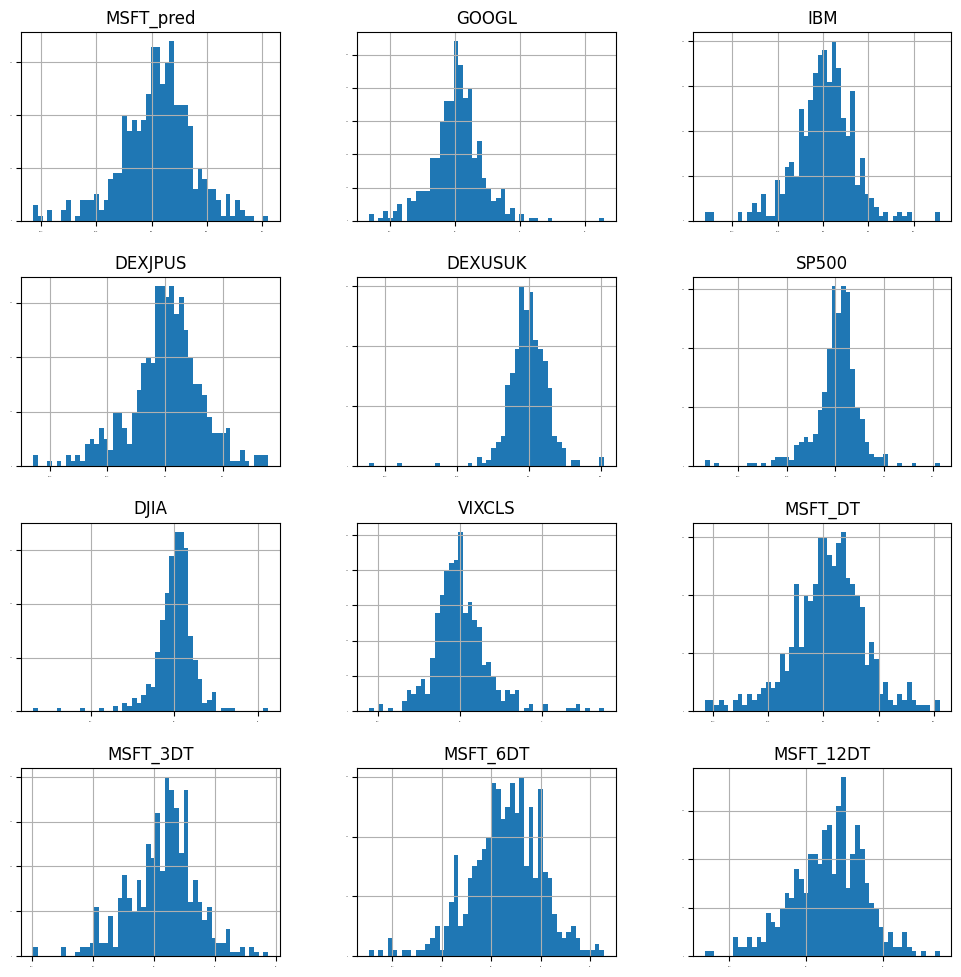

In [61]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

### ANÁLISE DA SÉRIE TEMPORAL

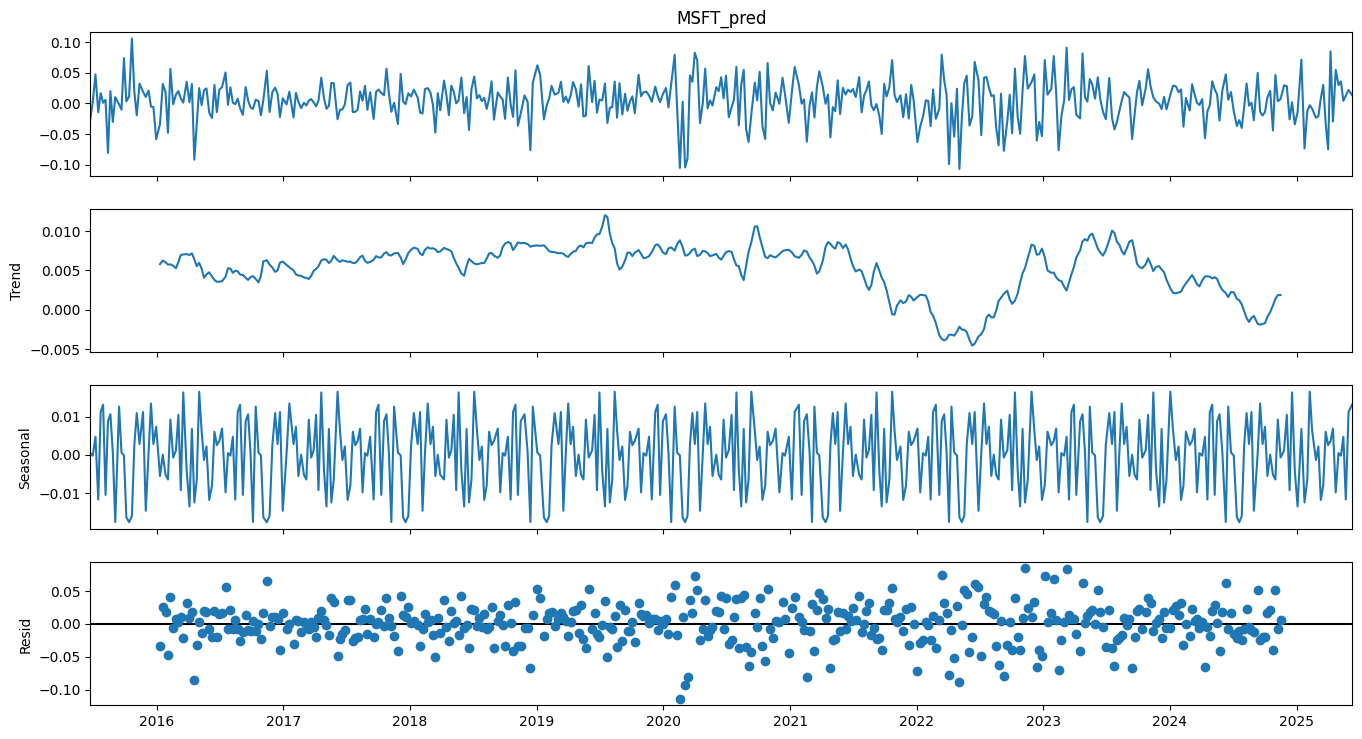

In [64]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## PREPARAÇÃO DOS DADOS

In [65]:
## TREINO E TESTE
validation_size = 0.2
train_size = int(len(X) * 1-(validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], X[train_size:len(X)]